In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor as RF
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
def prepare_train(df):
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
    df.loc[df['Rooms'] == 10, 'Rooms'] = 2 
    df.loc[df['Rooms'] == 19, 'Rooms'] = 1
    return df

In [4]:
def prepare_test(df):
    df.loc[df['Rooms'] > 6, 'Rooms'] = 7
    return df

In [5]:
def prepare_data(df):
    df = df.drop('Healthcare_1', axis=1)
    df.loc[df['Rooms'] > 5, 'Rooms'] = 5
    df.loc[df['Rooms'] == 0, 'Rooms'] = df['Square'] // 40 + 1
    df.loc[df['Square'] < (df['Rooms'] * 15), 'Square'] = df['Rooms'] * 15 + 10
    df.loc[df['Square'] > (df['Rooms'] * 40 + 40), 'Square'] = df['Rooms'] * 40 + 40
    df.loc[(df['Square'] < df['LifeSquare']), 'LifeSquare'] = df['Square']
    df['LifeSquare'] = df['LifeSquare'].fillna(df['Square'])
    df.loc[df['LifeSquare'] < (df['Rooms'] * 10), 'LifeSquare'] = df['Square']
    df['KitchenSquare'] = df['Square'] - df['LifeSquare']
    df.loc[df['KitchenSquare'] > df['LifeSquare'], ['LifeSquare', 'KitchenSquare']] = df.loc[df['KitchenSquare'] > df['LifeSquare'], ['KitchenSquare', 'LifeSquare']].values
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = np.round(df.loc[df['HouseFloor'] != 0, 'HouseFloor'].mean())
    df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df['HouseFloor']
    df = pd.get_dummies(df)
    return df

In [6]:
data = prepare_train(data)
data = prepare_data(data)

In [7]:
test = prepare_test(test)
test = prepare_data(test)

In [8]:
train, valid = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
stat1 = train.groupby(['DistrictId', 'Rooms'], as_index=False)[['Price']].mean().rename(columns={'Price':'mean_price'})

In [10]:
stat2 = train.groupby(['Rooms'], as_index=False)[['Price']].mean().rename(columns={'Price':'mean_price2'})

In [11]:
mean_price3 = train['Price'].mean()

In [12]:
def add_mean_price(df, stat1=stat1, stat2=stat2, mean_price=mean_price3):
    df = pd.merge(df, stat1, on=['DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, stat2, on='Rooms', how='left')
    
    df['mean_price2'] = df['mean_price2'].fillna(mean_price3)
    df['mean_price'] = df['mean_price'].fillna(df['mean_price2'])
    return df

In [13]:
train = add_mean_price(train)
valid = add_mean_price(valid)

In [14]:
distr_size = (train['DistrictId'].value_counts() > 180).astype(int).reset_index()
distr_size.columns = ['DistrictId', 'large_district']

In [15]:
def add_distr_size(df, distr_size):
    df = pd.merge(df, distr_size, on='DistrictId', how='left')
    df['large_district'] = df['large_district'].fillna(0)
    return df

In [16]:
train = add_distr_size(train, distr_size)

In [17]:
train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Price', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
       'mean_price', 'mean_price2', 'large_district'],
      dtype='object')

In [18]:
valid = add_distr_size(valid, distr_size)

In [19]:
features = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B', 'mean_price', 'large_district']

In [20]:
X_train, y_train = train.loc[:, features], train['Price']

In [21]:
X_valid, y_valid = valid.loc[:, features], valid['Price']

In [22]:
model = RF(n_estimators=100, max_depth=20, random_state=42)

In [23]:
model.fit(X_train.loc[:, features], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [24]:
y_valid_pred = model.predict(X_valid.loc[:, features])

In [25]:
r2(y_valid, y_valid_pred)

0.692508250513434

In [26]:
model.feature_importances_

array([1.39526194e-02, 1.06373653e-02, 1.03715715e-01, 3.53711146e-02,
       4.21193979e-02, 1.94961233e-02, 1.92072684e-02, 2.96248037e-02,
       1.54109462e-02, 1.24516558e-02, 1.48827553e-02, 1.97301977e-02,
       5.89075696e-03, 8.90636222e-03, 1.08211974e-04, 1.84260971e-04,
       4.12964500e-04, 3.79894937e-04, 4.59424683e-04, 4.93318247e-04,
       6.45369366e-01, 1.19547731e-03])

Text(0, 0.5, 'Признак')

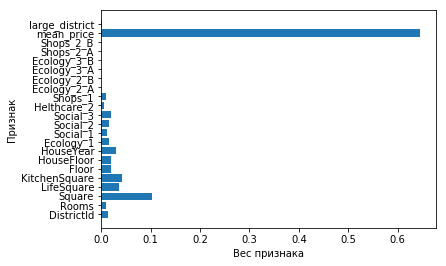

In [27]:
plt.barh(features, model.feature_importances_)
plt.xlabel('Вес признака')
plt.ylabel('Признак')

In [28]:
feats = [features[i] for i in range(len(features)) if model.feature_importances_[i] > 0.015]

In [29]:
feats

['Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_3',
 'mean_price']

In [31]:
model.fit(X_train.loc[:, feats], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [32]:
y_valid_pred = model.predict(X_valid.loc[:, feats])

In [33]:
r2(y_valid, y_valid_pred)

0.6863665659295326

In [34]:
y_train_pred = model.predict(X_train.loc[:, feats])

In [35]:
r2(y_train, y_train_pred)

0.9663431824512493

In [36]:
test = add_mean_price(test)

In [37]:
test = add_distr_size(test, distr_size)

In [38]:
test['Price'] = model.predict(test.loc[:, feats])

In [39]:
test['Price'].describe()

count      5000.000000
mean     213819.710485
std       79402.470044
min       65756.836215
25%      162834.481534
50%      195327.899426
75%      244780.939014
max      589762.654804
Name: Price, dtype: float64

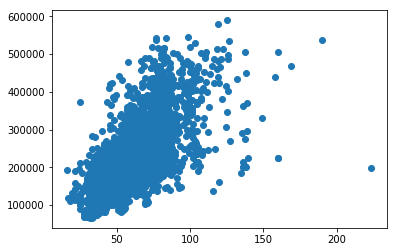

In [40]:
plt.scatter(test['Square'], test['Price'])

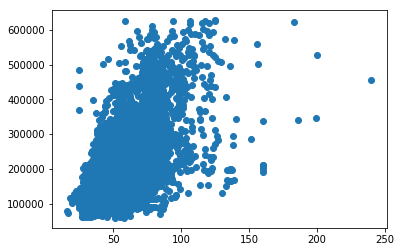

In [41]:
plt.scatter(X_train['Square'], y_train)

In [42]:
test.loc[:, ['Id', 'Price']].to_csv('EMaksimenko_predictions.csv', index=False)